# Network Analysis

This notebook provide analysis metrics on 3 complex networks: 

- [Amazon Co-purchase](http://snap.stanford.edu/data/com-Amazon.html)
- [Wikipedia Admin Election](http://snap.stanford.edu/data/wiki-Elec.html)

The following metrics are obtained: 

- Degree
- Distance 
- Closeness
- Betweenness

## Imports

In [40]:
import networkx as nx
from powerlaw import ccdf
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

## Processing Datafiles

For each dataset, a source file is processed in order to create an adjacency-list output file.

### Amazon Co-purchase

In [146]:
dataset_tag, dataset_file = "amazon_copurchase", "./com-amazon.ungraph.txt"
df = pd.read_csv(dataset_file, header=None, skiprows=4, sep='\t')
df.columns = ["from", "to"]
df.to_csv("./" + dataset_tag + "_edgelist.txt", sep='\t', index=False, header=None)
df.tail()

,from,to
925867,548343,548378
925868,548354,548356
925869,548368,548454
925870,548391,548411
925871,548411,548458


### Movie Lens 1M

In [94]:
dataset_tag, dataset_file = "ml1m", "./ratings.dat"
df = pd.read_csv(dataset_file, header=None, sep=r'::', engine="python")
df.columns = ["from", "to", "rating", "timestamp"]
df['from'] = df['from'].apply(lambda x: 'user_' + str(x))
df['to'] = df['to'].apply(lambda x: 'item_' + str(x))
df.drop(["timestamp"], axis=1, inplace=True)
df.to_csv("./" + dataset_tag + "_edgelist.txt", sep='\t', index=False, header=None)
df.head()

,from,to,rating
0,user_1,item_1193,5
1,user_1,item_661,3
2,user_1,item_914,3
3,user_1,item_3408,4
4,user_1,item_2355,5


## Creating Network

In [147]:
if dataset_tag == "ml1m":
    G = nx.DiGraph()
    G.add_weighted_edges_from(df[["from", "to", "rating"]].values)
else: 
    G = nx.read_edgelist("./" + dataset_tag + "_edgelist.txt", delimiter='\t', nodetype=str, data=(('weight',float),))
print (list(G.edges)[:3])
print ("Number of edges: ", G.number_of_edges())
print ("Number of nodes: ", G.number_of_nodes())


[('1', '88160'), ('1', '118052'), ('1', '161555')]
Number of edges:  925872
Number of nodes:  334863


In [34]:
# nx.diameter(G)

## Getting Stats
### Degrees

In [148]:
df_stats = pd.DataFrame(nx.degree(G))
df_stats.columns = ['node', 'degree']
df_stats['degree_centrality'] = nx.degree_centrality(G).values()
df_stats.head()

,node,degree,degree_centrality
0,1,8,0.000024
1,88160,7,0.000021
2,118052,18,0.000054
3,161555,31,0.000093
4,244916,26,0.000078


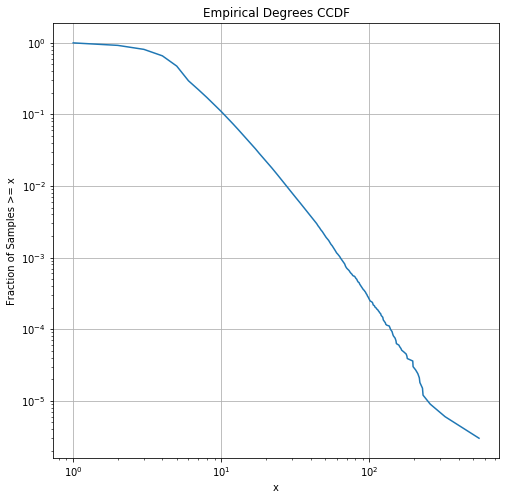

In [149]:
x, y = ccdf(df_stats["degree"])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
ax.set_title("Empirical Degrees CCDF")
ax.plot(x, y)
ax.set_xscale("log"), ax.set_yscale("log")
ax.set_xlabel("x"), ax.set_ylabel("Fraction of Samples >= x")
ax.grid(True)
plt.savefig("./images/{}_empirical_degrees_ccdf.jpeg".format(dataset_tag), bbox_inches="tight")

In [150]:
if dataset_tag == "ml1m":
    x, y = ccdf(df_stats[df_stats.node.str.contains("user")]["degree"])
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax.set_title("Empirical Out Degrees CCDF")
    ax.plot(x, y)
    ax.set_xscale("log"), ax.set_yscale("log")
    ax.set_xlabel("x"), ax.set_ylabel("Fraction of Samples >= x")
    ax.grid(True)
    plt.savefig("./images/{}_empirical_out_degrees_ccdf.jpeg".format(dataset_tag), bbox_inches="tight")
    
    x, y = ccdf(df_stats[df_stats.node.str.contains("item")]["degree"])
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax.set_title("Empirical In Degrees CCDF")
    ax.plot(x, y)
    ax.set_xscale("log"), ax.set_yscale("log")
    ax.set_xlabel("x"), ax.set_ylabel("Fraction of Samples >= x")
    ax.grid(True)
    plt.savefig("./images/{}_empirical_in_degrees_ccdf.jpeg".format(dataset_tag), bbox_inches="tight")
    

### Distance

In [151]:
%time
n_trial_nodes = 10
arr_dist = arr_close = np.array([])
for node in np.random.choice(df_stats["node"].unique(), size=n_trial_nodes):
    node_dist = np.array(list(nx.shortest_path_length(G, node).values())[1:])
    node_close = nx.closeness_centrality(G, node)
    arr_dist = np.append(arr_dist, node_dist)
    arr_close = np.append(arr_close, node_close)

Wall time: 0 ns


In [152]:
{"count": len(arr_dist), 
 "mean": arr_dist.mean(), 
 "std": arr_dist.std(), 
 "min": arr_dist.min(),
 "max": arr_dist.max()}

{'count': 3348620,
 'mean': 12.386744390226422,
 'std': 2.7329681086799194,
 'min': 1.0,
 'max': 35.0}

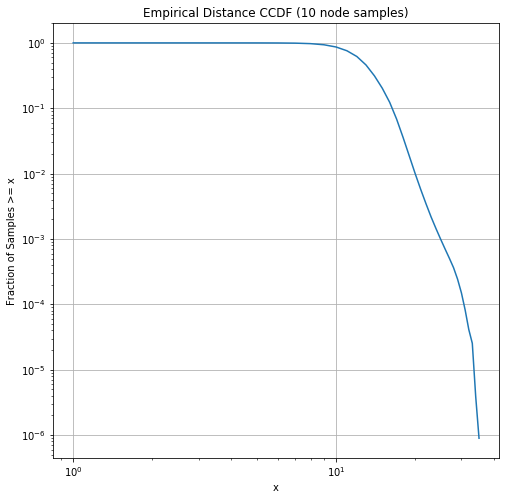

In [153]:
x, y = ccdf(arr_dist)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
ax.set_title("Empirical Distance CCDF ({} node samples)".format(n_trial_nodes))
ax.plot(x, y)
ax.set_xscale("log"), ax.set_yscale("log")
ax.set_xlabel("x"), ax.set_ylabel("Fraction of Samples >= x")
ax.grid(True)
plt.savefig("./images/{}_empirical_distances_ccdf.jpeg".format(dataset_tag), bbox_inches="tight")

In [72]:
# nx.betweenness_centrality(G, 1)

In [32]:
df_stats.describe()

,node,degree,degree_centrality
count,334863.000000,334863.000000,334863.000000
mean,276768.565727,5.529855,0.000017
std,159927.553896,5.761639,0.000017
min,1.000000,1.000000,0.000003
25%,138028.000000,3.000000,0.000009
50%,276405.000000,4.000000,0.000012
75%,415626.500000,6.000000,0.000018
max,548551.000000,549.000000,0.001639


In [179]:
G=nx.DiGraph()

G.add_edge('u1','i1',weight=0.6)
G.add_edge('u1','i2',weight=0.2)
G.add_edge('u2','i1',weight=0.1)

KeyError: 'a'

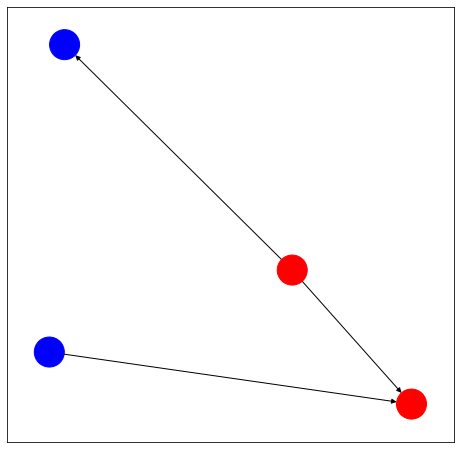

In [180]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
nx.draw(G,pos=nx.spring_layout(G), 
        label="uhu", 
        node_size=900, 
        node_color=['r', 'r', 'b', 'b'],
        labels={'u1': 'u1', 'u2': 'u2', 'i1': 'i1', 'd': 4},
        ax=ax)
plt.show()